In [4]:
import torch
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.nn.functional as F
import math 
from pennylane import qml


def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = x_shape[0]
    out = vals[t].expand(batch_size, *((1,) * (len(x_shape) - 1)))
    return out

def forward_diffusion_sample(x_0, t):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

timesteps = 10
betas = linear_beta_schedule(timesteps)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

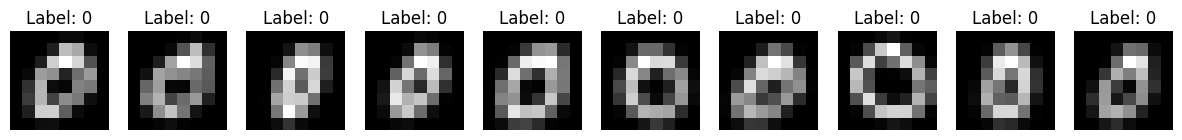

In [5]:
IMG_SIZE = 8  # Dimensione delle immagini (8x8)
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Ridimensiona le immagini a 8x8
    transforms.ToTensor()  # Converte le immagini in tensori
])

# Scarica il dataset MNIST con la trasformazione applicata
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Crea sottoinsiemi per le cifre 0 e 1
indices_zero = [i for i, (_, label) in enumerate(trainset) if label == 0]
indices_one = [i for i, (_, label) in enumerate(trainset) if label == 1]

zero_subset = Subset(trainset, indices_zero)
one_subset = Subset(trainset, indices_one)

# Combina i due sottoinsiemi
combined_subset = ConcatDataset([zero_subset, one_subset])

trainloader = DataLoader(combined_subset, batch_size=BATCH_SIZE, shuffle=True)

# Funzione per visualizzare le immagini
def show_images(dataset, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

# Visualizza alcune immagini del dataset combinato
show_images(combined_subset, num_images=10)

In [6]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(), # Scales data into [0,1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.MNIST(root=".", download=True, 
                                         transform=data_transform, train=True)

    test = torchvision.datasets.MNIST(root=".", download=True, 
                                         transform=data_transform, train=False)
    indices = [i for i, (_, label) in enumerate(train) if label == 0]
    train = Subset(train, indices)
    indices = [i for i, (_, label) in enumerate(test) if label == 0]
    test = Subset(test, indices)
    return torch.utils.data.ConcatDataset([train, test])
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

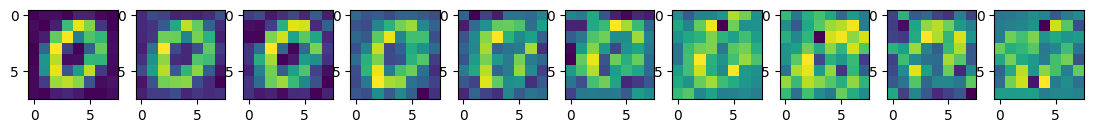

In [7]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
num_images = 10
stepsize = int(timesteps/num_images)

for t in range(0, timesteps, stepsize):
    plt.subplot(1, num_images+1, int(t/stepsize) + 1)
    img= forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [8]:
# Numero di qubit e layers per StronglyEntanglingLayers
n_encoding_qubits = 6

# Definiamo il dispositivo quantistico
dev = qml.device('default.qubit', wires=n_encoding_qubits)

@qml.qnode(dev)
def quantum_state(x):
    qml.AmplitudeEmbedding(x, wires=range(n_encoding_qubits), normalize=True)
    return qml.state()


In [9]:
class QuantumDenoising(nn.Module):
    def __init__(self, n_layers=25, n_qubits=7, n_qubits1=6, n_a_qubits=1, device='default.qubit.torch'):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_qubits1 = n_qubits1
        self.n_a_qubits = n_a_qubits
        self.n_layers = n_layers
        self.device = device

        self.dev = qml.device(self.device, wires=self.n_qubits)
        self.dev1 = qml.device(self.device, wires=self.n_qubits1)
        
        self.qnode = qml.QNode(self.circuit, self.dev, interface='torch')
        self.qnode1 = qml.QNode(self.circuit1, self.dev1, interface='torch')
        
        self.weight_shapes = {"weights": qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=self.n_qubits)}
        self.weight_shapes1 = {"weights": qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=self.n_qubits1)}
        
        self.qlayer = qml.qnn.TorchLayer(self.qnode, self.weight_shapes)
        self.qlayer1 = qml.qnn.TorchLayer(self.qnode1, self.weight_shapes1)

    def circuit(self, inputs, weights):
        qml.AmplitudeEmbedding(features=inputs, wires=range(self.n_qubits1), normalize=True)
        qml.StronglyEntanglingLayers(weights=weights, wires=range(self.n_qubits))
        return qml.state()
    
    def circuit1(self, inputs, weights):
        qml.AmplitudeEmbedding(features=inputs, wires=range(self.n_qubits1), normalize=True)
        qml.StronglyEntanglingLayers(weights=weights, wires=range(self.n_qubits1))
        return qml.state()
    
    def forward(self, x):
        probs = self.qlayer(x)
        probsgiven0 = probs[:, : (2 ** (self.n_qubits - self.n_a_qubits))]
        probsgiven0 /= torch.sum(probs)
        return self.qlayer1(probsgiven0)

In [62]:


def infidelity_loss(x0, x1):
    state0 = qml.math.dm_from_state_vector(x0)
    state1 = qml.math.dm_from_state_vector(x1)
    fidelity = qml.math.fidelity(state0, state1)
    loss = torch.mean(1 - fidelity)
    return loss

# Creazione dei modelli per ogni timestep
model = QuantumDenoising()
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 5

# Funzione per il processo di backward
def backward_process(epoch):
    losses = []
    
    # Iteriamo prima sui batch
    for step, batch in enumerate(tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs} - Batches', unit='batch')):
        data = batch[0].reshape(-1, 64)
        xt = None
        
        # Per ogni batch, iteriamo sui timestep in ordine inverso
        for t in tqdm(range(timesteps - 1, 0, -1), desc=f'Batch {step+1} - Timesteps', leave=False, unit='timestep'):
            optimizer.zero_grad()
            
            if t == timesteps - 1:
                xt = forward_diffusion_sample(data, t)
            else:
                xt = xt_prev

            x_target = quantum_state(forward_diffusion_sample(data, t-1))
            xt_prev = model(xt.detach())
            loss = infidelity_loss(x_target, xt_prev)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            
    return sum(losses) / len(losses)

In [63]:
for epoch in range(epochs):
    loss = backward_process(epoch)
    print(loss)

Epoch 1/5 - Batches: 100%|██████████| 396/396 [27:50<00:00,  4.22s/batch]


0.5412363805004015


Epoch 2/5 - Batches: 100%|██████████| 396/396 [27:49<00:00,  4.22s/batch]


0.4956673527022937


Epoch 3/5 - Batches: 100%|██████████| 396/396 [27:51<00:00,  4.22s/batch]


0.49084583189782677


Epoch 4/5 - Batches: 100%|██████████| 396/396 [27:47<00:00,  4.21s/batch]


0.4878762497003766


Epoch 5/5 - Batches: 100%|██████████| 396/396 [27:47<00:00,  4.21s/batch]

0.48500460540382995


In [ ]:
import pickle

losses = [0.5369305983083528,
          0.49174366281894283,
          0.4916757096709288,
          0.48622077312128553,
          0.4832182808761745]

# Salva le loss in un file
with open('epoch_losses10T8x8.pkl', 'wb') as f:
    pickle.dump(losses, f)

print("Le loss sono state salvate nel file 'epoch_losses.pkl'")

Le loss sono state salvate nel file 'epoch_losses.pkl'


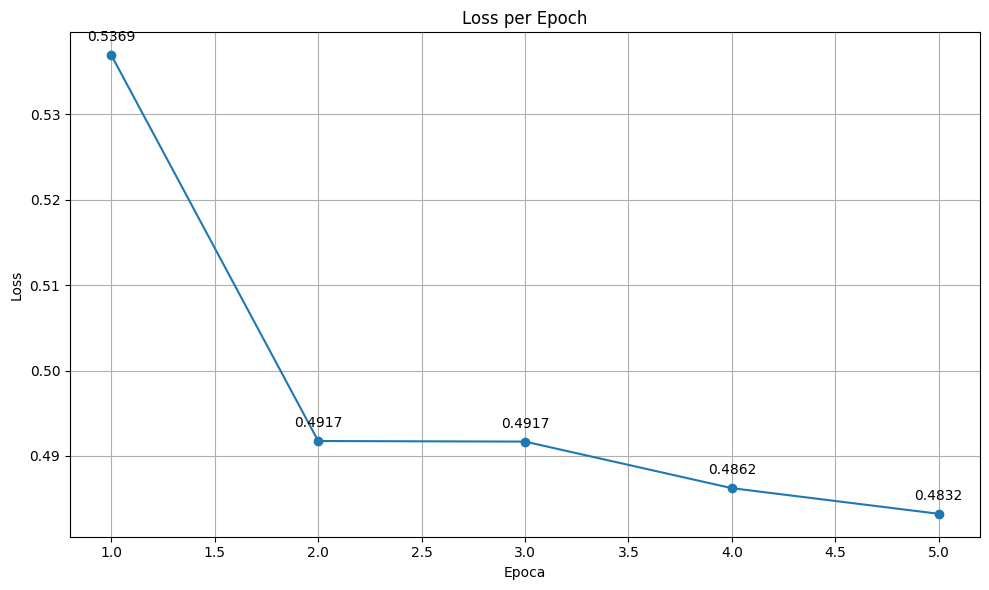

In [ ]:
with open('epoch_losses10T8x8.pkl', 'rb') as f:
    losses = pickle.load(f)

# Crea il grafico
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.grid(True)

# Aggiungi i valori delle loss sopra ogni punto
for i, loss in enumerate(losses):
    plt.annotate(f'{loss:.4f}', (i+1, loss), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

In [64]:
# SAVE

PATH = "model_weights_quantum_diffusion.pth"

# Salva i pesi del modello
torch.save(model.state_dict(), PATH)
print("Model weights saved.")

Model weights saved.


In [10]:
#LOAD
PATH = "model_weights_quantum_diffusion.pth"
model= QuantumDenoising()
model.load_state_dict(torch.load(PATH))
print("Model weights loaded.")

Model weights loaded.


Timesteps to show: [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


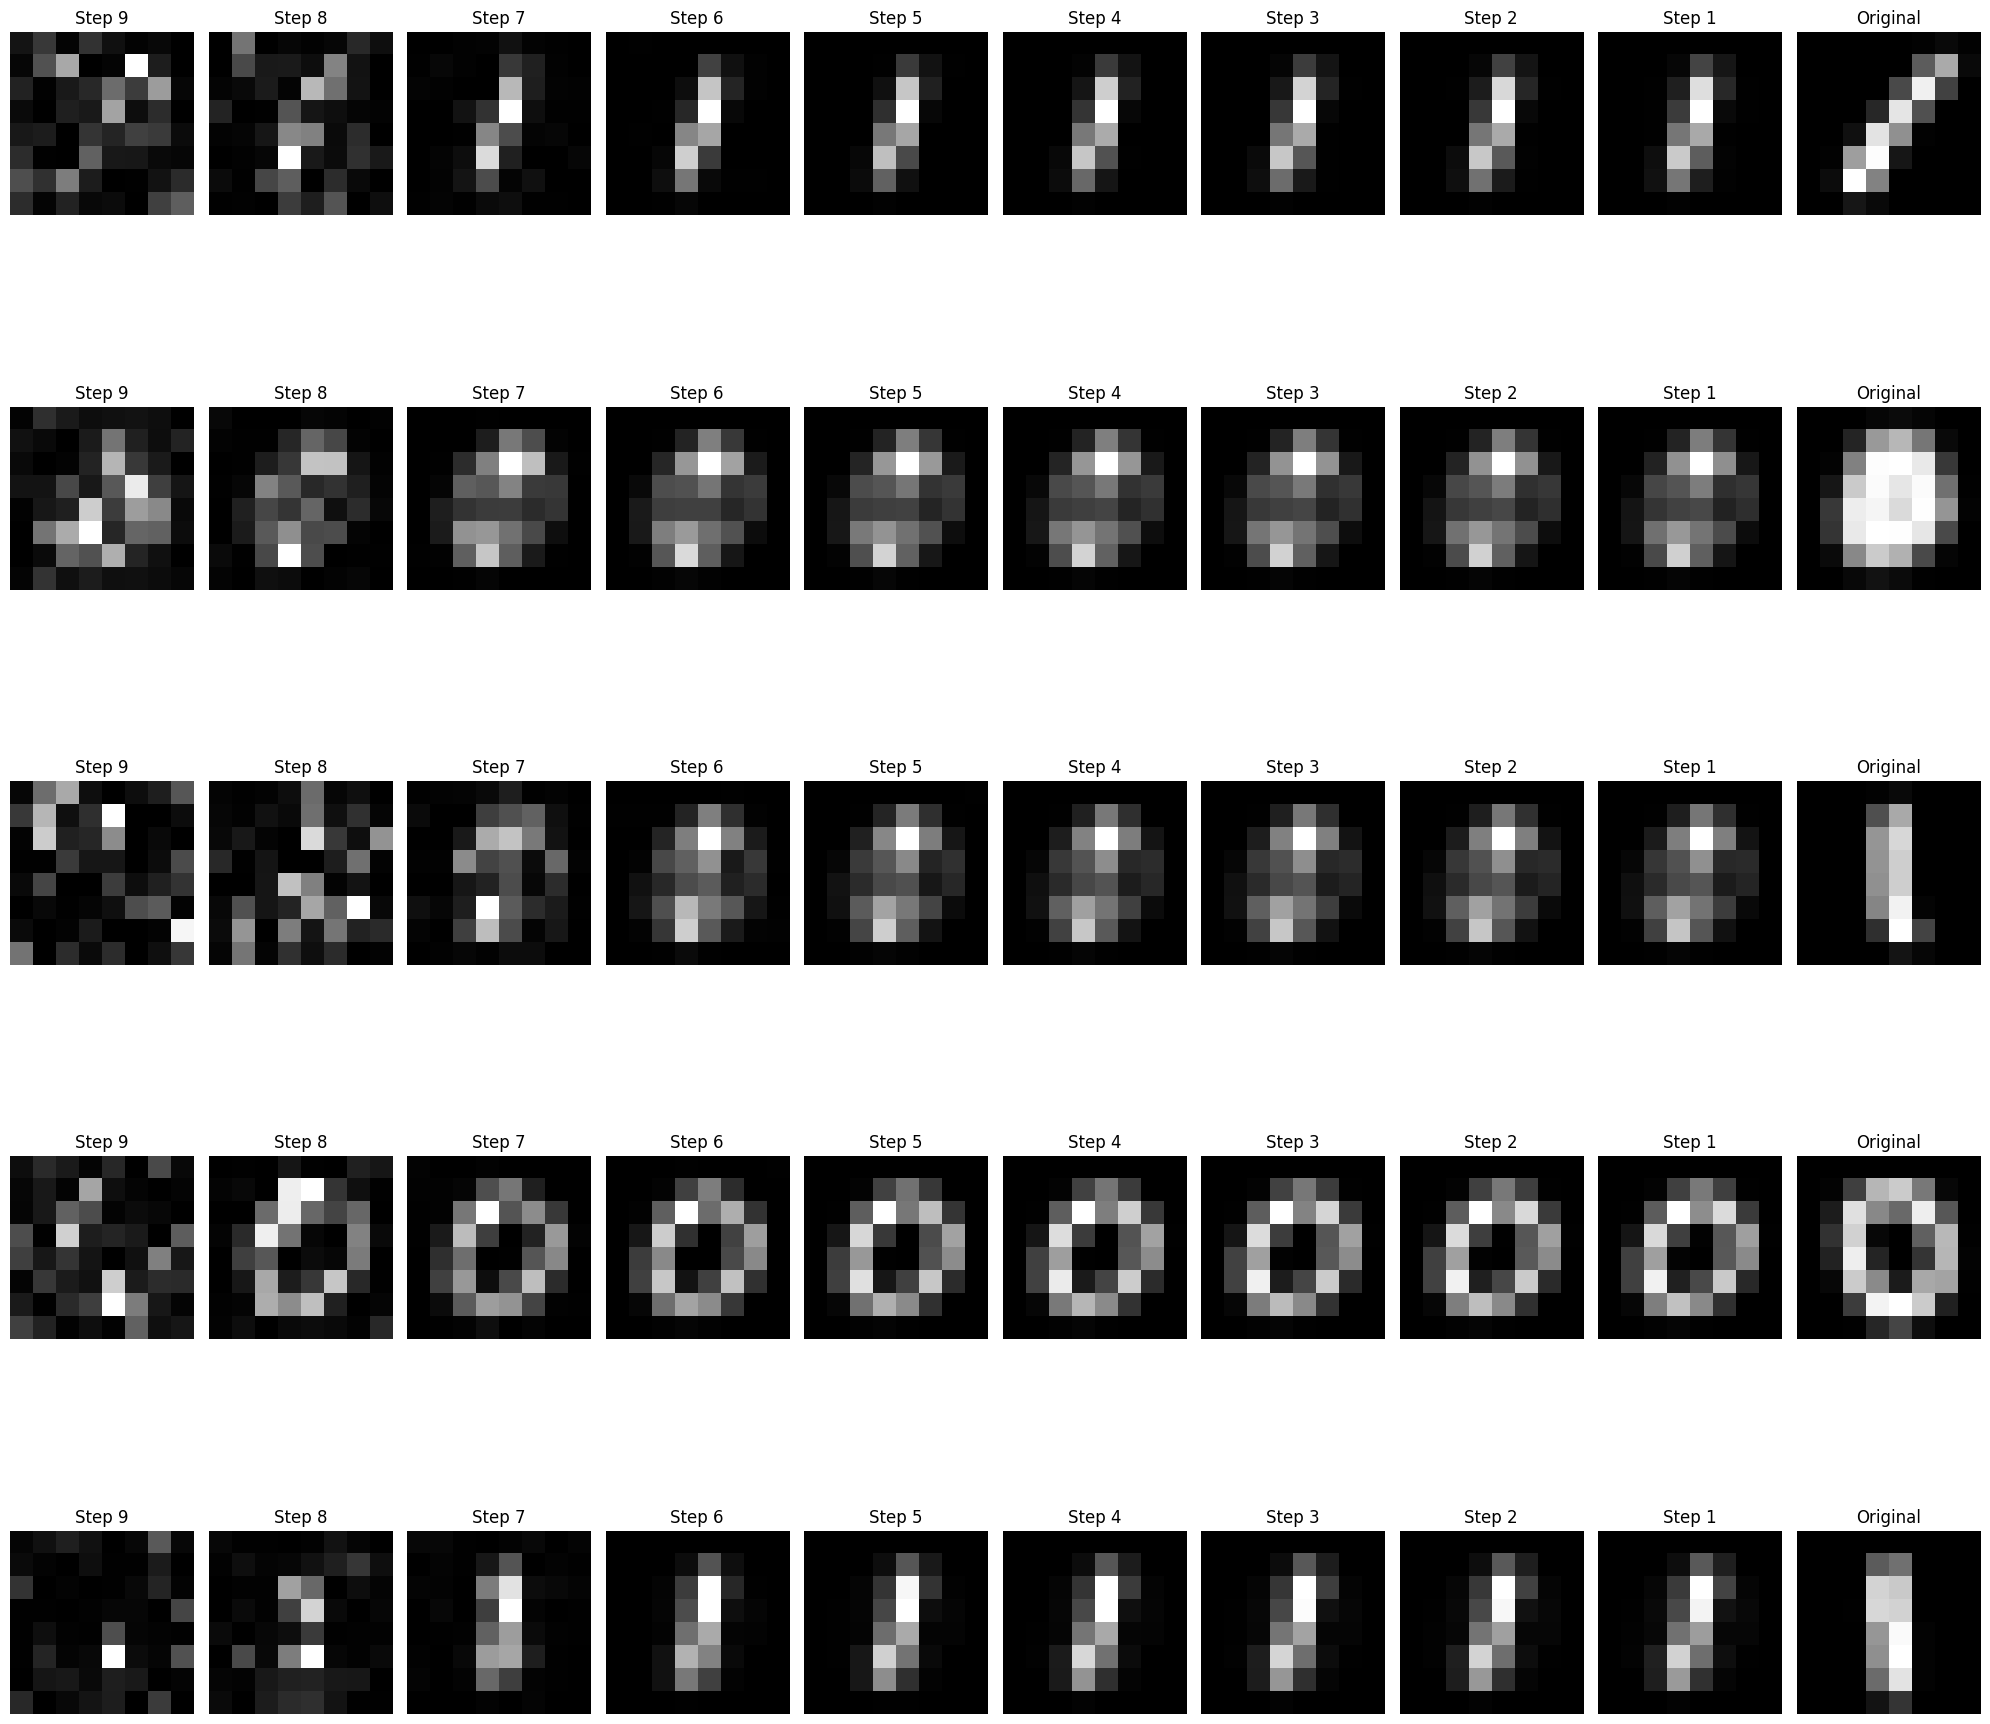

In [13]:

def display_denoising_grid(model, trainloader, timesteps, num_images=5):
    model.eval()
    
    # Choose timesteps to display
    timesteps_to_show = [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
    
    fig, axes = plt.subplots(num_images, len(timesteps_to_show), figsize=(20, 4 * num_images))
    print(f"Timesteps to show: {timesteps_to_show}")
    
    with torch.no_grad():
        for img_idx, batch in enumerate(trainloader):
            if img_idx >= num_images:
                break
            
            data = batch[0].reshape(-1, 64)
            
            # Initialize xt for the last timestep
            xt = forward_diffusion_sample(data, timesteps - 1)
            
            # Dictionary to store images at timesteps_to_show
            images_to_show = {}
            
            for t in range(timesteps - 1, -1, -1):
                if t in timesteps_to_show:
                    amplitudes = np.abs(xt.cpu().numpy()) ** 2
                    reconstructed_image = amplitudes.reshape(-1, IMG_SIZE, IMG_SIZE)
                    images_to_show[t] = reconstructed_image[img_idx]
                
                if t > 0:
                    xt = model(xt)
            
            # Display images
            for step_idx, t in enumerate(timesteps_to_show):
                if t == 0:
                    # Display original image
                    axes[img_idx, step_idx].imshow(batch[0][img_idx].squeeze().cpu(), cmap='gray')
                    axes[img_idx, step_idx].set_title("Original")
                else:
                    # Display denoised image
                    axes[img_idx, step_idx].imshow(images_to_show[t], cmap='gray')
                    axes[img_idx, step_idx].set_title(f"Step {t}")
                
                axes[img_idx, step_idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage
display_denoising_grid(model, trainloader, timesteps)

In [46]:
import os
from PIL import Image

def save_images(images, labels, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i, (image, label) in enumerate(zip(images, labels)):
        img = transforms.ToPILImage()(image.squeeze())
        img.save(os.path.join(directory, f'real_image_{i:04d}_label_{label.item()}.png'))

def save_mnist_images(dataset, save_path='qdm_images/real_images'):
    label_counts = {0: 0, 1: 0}
    images = []
    labels = []
    
    for img, label in dataset:
        if label not in [0, 1] or label_counts[label] >= 50:
            continue
        
        images.append(img)
        labels.append(label)
        label_counts[label] += 1
        
        if len(images) >= 100:
            break
    
    save_images(images, labels, save_path)
    
    print(f"Saved {len(images)} real MNIST images to {save_path}")
    print(f"Label 0: {label_counts[0]} images")
    print(f"Label 1: {label_counts[1]} images")

In [48]:
def save_images(images, labels, directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i, (image, label) in enumerate(zip(images, labels)):
        img = transforms.ToPILImage()(image.squeeze())
        img.save(os.path.join(directory, f'diffusion_image_{i:04d}_label_{label.item()}.png'))

def apply_diffusion_and_save(model, real_images_path, timesteps, batch_size=32, save_path='qdm_images/denoised_images'):
    model.eval()  # Set the model to evaluation mode
    
    # Define image transformation
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])
    
    image_files = [f for f in os.listdir(real_images_path) if f.endswith('.png')]
    image_index = 0
    
    with torch.no_grad():
        for i in tqdm(range(0, len(image_files), batch_size), desc="Processing batches"):
            batch_files = image_files[i:i+batch_size]
            batch = []
            labels = []
            
            for file in batch_files:
                img_path = os.path.join(real_images_path, file)
                image = Image.open(img_path)
                image = transform(image)
                batch.append(image)
                label = int(file.split('_label_')[1].split('.')[0])
                labels.append(label)
            
            batch = torch.stack(batch)
            labels = torch.tensor(labels)
            
            # Reshape the batch to 2D (batch_size, 64)
            x0 = batch.view(batch.size(0), -1)
            
            # Apply the denoising process
            for t in range(timesteps - 1, 0, -1):
                if t == timesteps - 1:
                    xt = forward_diffusion_sample(x0, t)
                else:
                    xt = xt_prev
                
                xt_prev = model(xt)
            
            # The final xt is our batch of generated images at timestep 1
            amplitudes = np.abs(xt_prev.cpu().numpy()) ** 2
            generated_imgs = torch.from_numpy(amplitudes).float().view(batch.size(0), 1, IMG_SIZE, IMG_SIZE)
            print(generated_imgs.dtype)
            print(generated_imgs[0])
            # Save the batch of generated images
            save_images(generated_imgs, labels, save_path)
            
            image_index += len(generated_imgs)
    
    print(f"Saved {image_index} diffusion images to {save_path}")

# Usage
real_images_path = 'qdm_images/real_images'
apply_diffusion_and_save(model, real_images_path, timesteps, batch_size=32)

Processing batches:  25%|██▌       | 1/4 [00:00<00:02,  1.04it/s]

torch.float32
tensor([[[1.1457e-05, 7.6794e-05, 4.2054e-06, 2.9583e-04, 2.1495e-06,
          4.5541e-05, 1.1944e-05, 2.2536e-04],
         [7.1989e-05, 1.6621e-04, 8.9217e-04, 1.9081e-02, 4.2886e-02,
          2.0875e-02, 3.9572e-04, 6.4592e-06],
         [2.6780e-06, 4.5807e-04, 2.5353e-02, 7.6819e-02, 5.9670e-02,
          6.8333e-02, 1.6280e-02, 7.2401e-06],
         [1.0517e-05, 5.8754e-03, 5.7982e-02, 2.4143e-02, 6.2857e-03,
          2.6087e-02, 4.2985e-02, 2.8966e-04],
         [1.9272e-07, 1.7084e-02, 4.3036e-02, 4.7260e-03, 2.0842e-03,
          2.4591e-02, 3.7109e-02, 6.5619e-05],
         [4.2384e-08, 1.7399e-02, 6.9588e-02, 2.0504e-02, 2.9438e-02,
          5.5226e-02, 1.1043e-02, 1.2823e-04],
         [1.6179e-04, 1.8361e-03, 3.8419e-02, 6.8907e-02, 4.3282e-02,
          1.4031e-02, 2.0872e-04, 8.7689e-05],
         [6.8452e-06, 1.3901e-05, 8.0586e-04, 2.0112e-03, 5.9665e-04,
          9.4778e-06, 1.7337e-05, 3.2261e-05]]])


Processing batches:  50%|█████     | 2/4 [00:01<00:01,  1.06it/s]

torch.float32
tensor([[[1.9933e-05, 8.4107e-05, 3.4246e-06, 3.2873e-04, 5.1987e-06,
          5.4542e-05, 1.8073e-05, 2.5630e-04],
         [8.2927e-05, 1.3221e-04, 7.7753e-04, 1.7456e-02, 4.7871e-02,
          2.1778e-02, 4.3380e-04, 5.3795e-06],
         [2.5034e-07, 4.1795e-04, 2.0758e-02, 7.1161e-02, 7.9928e-02,
          6.6193e-02, 1.3684e-02, 4.0088e-06],
         [6.1470e-06, 4.7432e-03, 4.5511e-02, 2.9329e-02, 2.1018e-02,
          2.3939e-02, 3.4258e-02, 2.4181e-04],
         [1.1238e-07, 1.3338e-02, 3.4197e-02, 1.2411e-02, 1.0327e-02,
          2.0321e-02, 2.9434e-02, 3.8223e-05],
         [1.1542e-07, 1.3787e-02, 6.0817e-02, 3.6848e-02, 3.7885e-02,
          4.5249e-02, 8.5451e-03, 1.1874e-04],
         [1.6888e-04, 1.5815e-03, 3.5974e-02, 7.8042e-02, 4.2656e-02,
          1.2005e-02, 1.7843e-04, 1.0466e-04],
         [7.6441e-06, 4.2673e-06, 7.8559e-04, 2.1761e-03, 6.0611e-04,
          8.9053e-06, 1.2674e-05, 4.7839e-05]]])


Processing batches:  75%|███████▌  | 3/4 [00:02<00:00,  1.06it/s]

torch.float32
tensor([[[6.4662e-05, 7.5176e-05, 4.0077e-07, 3.3251e-04, 2.5400e-05,
          7.0007e-05, 4.4446e-05, 2.8578e-04],
         [9.4863e-05, 1.2762e-05, 1.9737e-04, 6.5431e-03, 4.8882e-02,
          1.6658e-02, 3.9859e-04, 9.5029e-07],
         [1.9723e-05, 1.5115e-04, 2.8066e-03, 2.8752e-02, 1.4429e-01,
          3.4659e-02, 2.4389e-03, 1.8816e-06],
         [1.0999e-06, 5.3390e-04, 3.3337e-03, 4.0052e-02, 1.4551e-01,
          8.8997e-03, 3.1976e-03, 4.1463e-05],
         [1.2135e-05, 8.8452e-04, 2.9934e-03, 6.8113e-02, 9.4757e-02,
          2.9894e-03, 2.5639e-03, 9.3004e-06],
         [6.2977e-06, 1.1661e-03, 1.5649e-02, 1.2236e-01, 6.1568e-02,
          6.1225e-03, 4.8866e-04, 4.6332e-05],
         [1.3036e-04, 3.5733e-04, 1.5410e-02, 8.3896e-02, 2.5028e-02,
          2.5974e-03, 3.8136e-05, 1.3652e-04],
         [6.8341e-06, 2.5944e-05, 4.2685e-04, 1.9467e-03, 4.1692e-04,
          4.8042e-06, 2.6615e-07, 1.1114e-04]]])


Processing batches: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]

torch.float32
tensor([[[4.5298e-05, 8.6741e-05, 1.4841e-06, 3.6015e-04, 1.6019e-05,
          6.8307e-05, 3.4096e-05, 2.9625e-04],
         [9.7328e-05, 5.4066e-05, 4.4042e-04, 1.1632e-02, 5.2809e-02,
          2.0558e-02, 4.5430e-04, 2.6553e-06],
         [5.3930e-06, 2.7453e-04, 9.4170e-03, 4.9104e-02, 1.2409e-01,
          5.1618e-02, 6.8234e-03, 2.3192e-08],
         [2.3785e-07, 2.0330e-03, 1.7316e-02, 3.8345e-02, 8.4125e-02,
          1.5956e-02, 1.3922e-02, 1.1884e-04],
         [4.8592e-06, 4.9587e-03, 1.3666e-02, 4.1657e-02, 5.1533e-02,
          9.4965e-03, 1.1732e-02, 1.1687e-06],
         [2.6830e-06, 5.4611e-03, 3.4778e-02, 8.5868e-02, 5.5039e-02,
          2.0546e-02, 3.0552e-03, 8.1139e-05],
         [1.5952e-04, 8.6103e-04, 2.5533e-02, 8.8695e-02, 3.5067e-02,
          6.4044e-03, 9.4172e-05, 1.3305e-04],
         [8.0419e-06, 4.0550e-06, 6.2356e-04, 2.2338e-03, 5.3922e-04,
          6.8318e-06, 3.6916e-06, 8.7152e-05]]])
Saved 100 diffusion images to qdm_images/denoise